# Function to compare manual segmentation

This notebook goes through folders of manually segmented images and compares the results.  

Currently the folders are set up like this:

```
20230722-Human_Segmentation
    a_walk_in_the_park
        Maryam_GT - Maryam Berijanian.png
        a_walk_in_the_park copy_GT - Katie Reagan.jpg
        a_walk_in_the_park_GT - Catalina Diaz.jpg
        a_walk_in_the_park_GT - Dirk Colbry.png
        a_walk_in_the_park_Nathan_Haut_GT - Nathaniel haut.jpg
        a_walk_in_the_park_navya_GT - navya bhardwaj.jpg
    Mushrooms_GT
        Maryam_GT - Maryam Berijanian(1).png
        Mushrooms_GT - Dirk Colbry.png
        Mushrooms_GT - Katie Reagan.jpeg
        Mushrooms_Nathan_Haut_GT - Nathaniel haut.jpeg
        Mushrooms_navya_GT - navya bhardwaj.jpeg
    Waterbottle
        Maryam_GT - Maryam Berijanian(2).png
        Maryam_GT - Maryam Berijanian(3).png
        Waterbottle copy_GT - Katie Reagan.png
        Waterbottle_GT - Dirk Colbry.png
        Waterbottle_Nathan_Haut_GT - Nathaniel haut.jpg
        Waterbottle_navya_GT - navya bhardwaj.jpg
        catalina_GT - Catalina Diaz.jpg
```

I also copied in the masks from the see-segment folder and deleted on of the masks that included the original RGB image as background.

In [1]:
# Add path to the see folder in see-segment

import sys
sys.path.append('../see-segment/')

In [2]:
import see

# Path to the folder of manually selected images

I named mine 20230722-Human_Segmentation 

In [3]:
# Modified from code by navya
import pathlib
imagepath = pathlib.Path('20230722-Human_Segmentation/')
GTS = imagepath.glob('*')
image_folders = list(GTS)
image_folders

[PosixPath('20230722-Human_Segmentation/a_walk_in_the_park'),
 PosixPath('20230722-Human_Segmentation/Waterbottle'),
 PosixPath('20230722-Human_Segmentation/Mushrooms_GT')]

# Load two images and compare them
This example uses images that start with Mush

In [4]:
from cleaner import cleaner

In [5]:
import imageio.v3 as Image
imagepath = image_folders[0]
print(f' Testing images from {imagepath.name}')
myset = list(imagepath.glob('*'))
print(myset[0])
print(myset[1])

 Testing images from a_walk_in_the_park
20230722-Human_Segmentation/a_walk_in_the_park/Maryam_GT - Maryam Berijanian.png
20230722-Human_Segmentation/a_walk_in_the_park/a_walk_in_the_park_navya_GT - navya bhardwaj.jpg


In [6]:
im1 = Image.imread(myset[0])


In [7]:
mask1 = im1[:,:,0]
clean_mask1 = mask1 > 127

In [8]:
im2 = Image.imread(myset[1])
mask2 = im2[:,:,0]
clean_mask2 = mask2 > 127

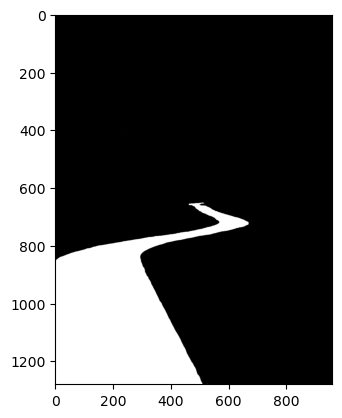

In [9]:
import matplotlib.pylab as plt

plt.imshow(im1)

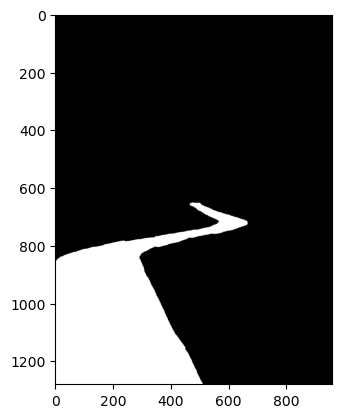

In [10]:
plt.imshow(im2)

# Now run fitness function

In [11]:
import see.Segment_Fitness as Fitness

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
output = Fitness.FitnessFunction(mask1,mask2)

In [13]:
output

[0.9381031658398798, 35, 256]

In [14]:
output[0]

0.9381031658398798

In [15]:
clean_output = Fitness.FitnessFunction(clean_mask1,clean_mask2)
clean_output[0]

0.0027750651041666668

# Loop and Load/Clean up the images

In [16]:
import numpy as np
all_orig_images = dict()
all_orig_masks = dict()
all_clean_masks = dict()
all_names = dict()

for f, folder in enumerate(image_folders):
    images = list(folder.glob('*g'))
    names = []
    orig_images = dict()
    orig_masks = dict()
    clean_masks = dict()
    for i, im_file in enumerate(images):
        im = Image.imread(im_file)
        myname = im_file.name
        names.append(myname)
        if len(im.shape) > 2:
            mask = im[:,:,0]
        else:
            mask = im
        clean_mask = mask > mask.max()/2 #Magic Cleaning code
        
        orig_images[myname] = im
        orig_masks[myname] = mask
        clean_masks[myname] = clean_mask
    all_names[folder.name] = names
    all_orig_images[folder.name] = orig_images
    all_orig_masks[folder.name] = orig_masks
    all_clean_masks[folder.name] = clean_masks

In [17]:
all_names

{'a_walk_in_the_park': ['Maryam_GT - Maryam Berijanian.png',
  'a_walk_in_the_park_navya_GT - navya bhardwaj.jpg',
  'a_walk_in_the_park copy_GT - Katie Reagan.jpg',
  'a_walk_in_the_park_GT - Dirk Colbry.png',
  'a_walk_in_the_park_GT - Catalina Diaz.jpg',
  'a_walk_in_the_park_Nathan_Haut_GT - Nathaniel haut.jpg',
  'a_walk_in_the_park_GT.jpg'],
 'Waterbottle': ['Waterbottle_navya_GT - navya bhardwaj.jpg',
  'Waterbottle_Nathan_Haut_GT - Nathaniel haut.jpg',
  'catalina_GT - Catalina Diaz.jpg',
  'Maryam_GT - Maryam Berijanian(2).png',
  'Waterbottle_GT.jpg',
  'Waterbottle copy_GT - Katie Reagan.png',
  'Waterbottle_GT - Dirk Colbry.png'],
 'Mushrooms_GT': ['Mushrooms_GT - Dirk Colbry.png',
  'Mushrooms_GT.png',
  'Mushrooms_GT - Katie Reagan.jpeg',
  'Mushrooms_Nathan_Haut_GT - Nathaniel haut.jpeg',
  'Maryam_GT - Maryam Berijanian(1).png',
  'Mushrooms_navya_GT - navya bhardwaj.jpeg',
  'catalina_GT - Catalina Diaz.jpeg']}

# Generate a "Segmentation Difference" figure

Convert the image masks to binary images and then add them up.  If everyone agrees on a pixel it should have a value of maxvalue (7 in these images). If everyone agrees in the background it should have a value of zero. All else are someplace in between. 

In [18]:
print(list(all_names.keys()))

['a_walk_in_the_park', 'Waterbottle', 'Mushrooms_GT']


In [19]:
key = 'a_walk_in_the_park'
key = 'Waterbottle'
#key = 'Mushrooms_GT'

In [20]:
import numpy as np

composit_diff = dict()

for folder in all_names:
    composit_im = ''
    first = True
    for name in all_clean_masks[folder]:
        clean_mask = all_clean_masks[folder][name]
        
        # Small hack to make sure images line up (not needed for fitness)
        if clean_mask[0,0]:
            clean_mask = np.invert(clean_mask)
            
        if first:
            composit_im = clean_mask*1
            first = False
        else:
            composit_im += clean_mask*1
    composit_diff[folder] = composit_im

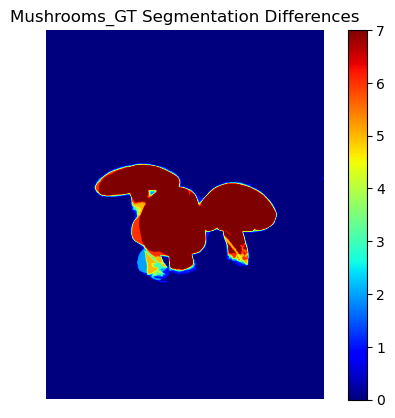

In [21]:
for key in all_names:
    plt.close()
    plt.imshow(composit_diff[key],cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title(f"{key} Segmentation Differences")
    #plt.tight_layout()
    plt.savefig(f"{key}_Segmentation_Differences.png")


# This code is a bit slow but works. Generates tables of before and after cleaning

In [22]:
import numpy as np

result_tables = dict()
clean_result_tables = dict()

for folder in all_names:
    print(folder)
    values = np.zeros([len(all_names[folder]), len(all_names[folder])])
    clean_values = np.zeros([len(all_names[folder]), len(all_names[folder])])
    for i,name1 in enumerate(all_names[folder]):
        print(f'--{name1}')
        for j,name2 in enumerate(all_names[folder]):
            mask1 = all_orig_masks[folder][name1]
            mask2 = all_orig_masks[folder][name2]
            out = Fitness.FitnessFunction(mask1,mask2)
            values[i,j] = out[0]
            
            clean_mask1 = all_clean_masks[folder][name1]
            clean_mask2 = all_clean_masks[folder][name2]
            clean_out = Fitness.FitnessFunction(clean_mask1,clean_mask2)
            clean_values[i,j] = clean_out[0]
            
    result_tables[folder] = values
    clean_result_tables[folder] = clean_values    
    all_names[folder] = names

a_walk_in_the_park
--Maryam_GT - Maryam Berijanian.png
--a_walk_in_the_park_navya_GT - navya bhardwaj.jpg
--a_walk_in_the_park copy_GT - Katie Reagan.jpg
--a_walk_in_the_park_GT - Dirk Colbry.png
--a_walk_in_the_park_GT - Catalina Diaz.jpg
--a_walk_in_the_park_Nathan_Haut_GT - Nathaniel haut.jpg
--a_walk_in_the_park_GT.jpg
Waterbottle
--Waterbottle_navya_GT - navya bhardwaj.jpg
--Waterbottle_Nathan_Haut_GT - Nathaniel haut.jpg
--catalina_GT - Catalina Diaz.jpg
--Maryam_GT - Maryam Berijanian(2).png
--Waterbottle_GT.jpg
--Waterbottle copy_GT - Katie Reagan.png
--Waterbottle_GT - Dirk Colbry.png
Mushrooms_GT
--Mushrooms_GT - Dirk Colbry.png
--Mushrooms_GT.png
--Mushrooms_GT - Katie Reagan.jpeg
--Mushrooms_Nathan_Haut_GT - Nathaniel haut.jpeg
--Maryam_GT - Maryam Berijanian(1).png
--Mushrooms_navya_GT - navya bhardwaj.jpeg
--catalina_GT - Catalina Diaz.jpeg


# Look at the results

In [23]:
labels = []

for i in range(len(result_tables[key])):
    labels.append(f"Subject {i+1}")
labels

['Subject 1',
 'Subject 2',
 'Subject 3',
 'Subject 4',
 'Subject 5',
 'Subject 6',
 'Subject 7']

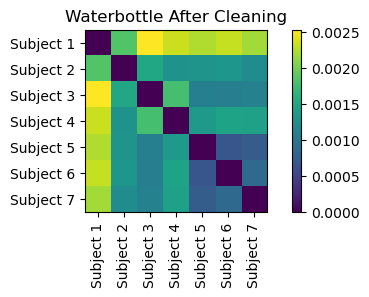

In [24]:
for key in ['Waterbottle']:#result_tables:
    plt.close()
    plt.imshow(result_tables[key])
    #plt.xticks(ticks=range(len(all_names[key])), labels=all_names[key], rotation='vertical')
    #plt.yticks(ticks=range(len(all_names[key])), labels=all_names[key])
    plt.xticks(ticks=range(len(all_names[key])), labels=labels, rotation='vertical')
    plt.yticks(ticks=range(len(all_names[key])), labels=labels)
    plt.title(f"{key} Before Cleaning")
    plt.colorbar()
    plt.gcf().subplots_adjust(bottom=0.5)
    plt.savefig(f'{key}_before_cleaning.png')

    plt.close()
    plt.imshow(clean_result_tables[key])
    plt.title(f"{key} After Cleaning")
    #plt.xticks(ticks=range(len(all_names[key])), labels=all_names[key], rotation='vertical')
    #plt.yticks(ticks=range(len(all_names[key])), labels=all_names[key])
    plt.xticks(ticks=range(len(all_names[key])), labels=labels, rotation='vertical')
    plt.yticks(ticks=range(len(all_names[key])), labels=labels)
    plt.colorbar()
    
    plt.gcf().subplots_adjust(bottom=0.5)
    plt.savefig(f'{key}_after_cleaning.png')

In [25]:
clean_result_tables[key]

array([[0.        , 0.00184001, 0.00253174, 0.00233073, 0.00223145,
        0.00231283, 0.00218424],
       [0.00184001, 0.        , 0.00151367, 0.00129476, 0.00130615,
        0.00132568, 0.00123128],
       [0.00253174, 0.00151367, 0.        , 0.0017863 , 0.00109619,
        0.00107829, 0.0011141 ],
       [0.00233073, 0.00129476, 0.0017863 , 0.        , 0.00136393,
        0.00146484, 0.00144857],
       [0.00223145, 0.00130615, 0.00109619, 0.00136393, 0.        ,
        0.00068034, 0.00074707],
       [0.00231283, 0.00132568, 0.00107829, 0.00146484, 0.00068034,
        0.        , 0.00086589],
       [0.00218424, 0.00123128, 0.0011141 , 0.00144857, 0.00074707,
        0.00086589, 0.        ]])

In [26]:
indices = np.where(clean_result_tables[key].max())
print(indices)

(array([0]),)


In [27]:
im_files = list(all_clean_masks[key].keys())
im_files

['Waterbottle_navya_GT - navya bhardwaj.jpg',
 'Waterbottle_Nathan_Haut_GT - Nathaniel haut.jpg',
 'catalina_GT - Catalina Diaz.jpg',
 'Maryam_GT - Maryam Berijanian(2).png',
 'Waterbottle_GT.jpg',
 'Waterbottle copy_GT - Katie Reagan.png',
 'Waterbottle_GT - Dirk Colbry.png']

Waterbottle_GT - Dirk Colbry.png


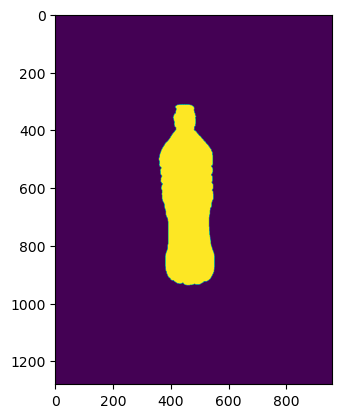

In [28]:
num=6
print(im_files[num])
plt.imshow(all_clean_masks[key][im_files[num]])

# Calculate Errors

In [29]:
# Original Average
np.sum(result_tables[key])/ ((len(result_tables[key])-1)**2)

0.8804797722987842

In [30]:
# Clean Average
np.sum(clean_result_tables[key])/ ((len(clean_result_tables[key])-1)**2)

0.0017637803819444448

# Calculate before and after for everything and plot as a bar graph

In [31]:
before_average = dict()
after_average = dict()

for key in result_tables:
    size = (len(result_tables[key])-1)**2
    before_average[key] = np.sum(result_tables[key])/size

    after_average[key] = np.sum(clean_result_tables[key])/size

In [32]:
before_average

{'a_walk_in_the_park': 0.789815468553785,
 'Waterbottle': 0.8804797722987842,
 'Mushrooms_GT': 0.8380624823916656}

In [33]:
after_average

{'a_walk_in_the_park': 0.0030958839699074072,
 'Waterbottle': 0.0017637803819444448,
 'Mushrooms_GT': 0.011373943752712674}

In [34]:
import numpy as np
a = np.array([[1,2,3], [4,3,1]])  # Can be of any shape
indices = np.where(a == a.max())

In [35]:
order = ['Waterbottle', 'a_walk_in_the_park', 'Mushrooms_GT']

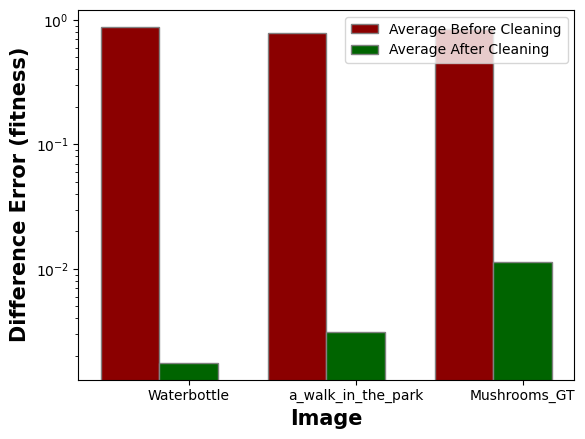

In [36]:
# set width of bar
barWidth = 0.35
#fig = plt.subplots(figsize =(12, 8))

before = []
after = []
names = []

for name in order:
    before.append(before_average[name])
    after.append(after_average[name])
    names.append(name)

# Set position of bar on X axis
br1 = np.arange(len(before))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, before, color ='darkred', width = barWidth,
        edgecolor ='grey', label ='Average Before Cleaning')
plt.bar(br2, after, color ='darkgreen', width = barWidth,
        edgecolor ='grey', label ='Average After Cleaning')
 
# Adding Xticks
plt.xlabel('Image', fontweight ='bold', fontsize = 15)
plt.ylabel('Difference Error (fitness)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(br1))], names)

plt.yscale("log") 

plt.legend() #loc='right')
plt.savefig('before_after_averages.png')